In [3]:
import pandas as pd
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### To translate the characters as labels (that will be used in BERT prediction), we used the followed relation:
<ol>
    <li>Character   -   Label</li>
    <li>Peter Griffin - 0</li>
    <li>Lois Griffin  - 1</li>
    <li>Stewie Griffin  - 2</li>
    <li>Meg Griffin  - 3</li>
    <li>Brian Griffin  - 4</li>
    <li>Glenn Quagmire - 5</li>
    <li>Chris Griffin - 6</li>
    <li>Joe Swanson - 7</li>
    <li>Tom Tucker - 8</li>
    <li>Cleveland Brown - 9</li>
</ol>

##### Functions or vars that are used to match label and characters

In [4]:
character_to_label = {
    "Peter Griffin": 0,
    "Lois Griffin": 1,
    "Stewie Griffin": 2,
    "Meg Griffin": 3,
    "Brian Griffin": 4,
}

# "Glenn Quagmire": 5,
# "Chris Griffin": 6,
# "Joe Swanson": 7,
# "Tom Tucker": 8,
# "Cleveland Brown": 9

# Create the reverse mapping from label to character name
label_to_character = {v: k for k, v in character_to_label.items()}

# Function to parse integer label to character name
def get_character_name(label):
    return label_to_character.get(label, "Unknown Label")

In [5]:
def load_family_guy_data(data_file, label_map):
    #load dataset
    dialogues = pd.read_csv('csv_files/family_guy_dataset_v2.csv', nrows = 100000)
    #Filter the dataset to dataset that just contains valid dialogues
    dialogues = dialogues[dialogues['Dialogue'].apply(lambda x: isinstance(x, str) and x.strip() != '')]

    #Filter the dataset to dataset that just contains valid characters linked with dialogues
    dialogues = dialogues[dialogues['Character'].apply(lambda x: isinstance(x, str) and x.strip() != '')]

    #Transform the mapped characters to its label, the unmapped characters will be NaN
    dialogues['Character'] = dialogues['Character'].map(label_map)

    # Remove rows where 'Character' column is NaN
    dialogues = dialogues.dropna(subset=['Character'])

    # Ensure the 'Character' column is converted to integers, because before is converted to number as 3.0, 1.0, ...
    dialogues['Character'] = dialogues['Character'].astype(int)

    # Save the filtered dataset to a new CSV file
    dialogues.to_csv('csv_files/family_guy_filtered_dataset.csv', index=False)

    # Check if all labels are within the valid range
    assert dialogues['Character'].between(0, len(label_map) - 1).all(), "Labels are out of range"
    
    texts = dialogues['Dialogue'].tolist()
    characters = dialogues['Character'].tolist()
    return texts, characters

In [6]:
data_file = "csv_files/family_guy_dataset.csv"
texts, labels = load_family_guy_data(data_file, character_to_label)

C:\Users\kamir\AppData\Local\Temp\ipykernel_10192\2754575423.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  dialogues = pd.read_csv('csv_files/family_guy_dataset_v2.csv', nrows = 100000)


### Sepate the dataset into dataset to train and dataset of test.

In [7]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

### Class definition that will be used to BERT Classification

So, in the code snippet you provided, when return_tensors='pt' is used in the tokenizer call, the tokenized text is returned as PyTorch tensors, which can then be directly used in PyTorch models for text classification tasks. In the context of the BERT tokenizer, return_tensors='pt' means that the tokenizer should return PyTorch tensors. When tokenizing text with BERT, the tokenizer usually returns tokenized sequences in the form of Python lists or other data structures. However, when return_tensors='pt' is specified, the tokenizer converts these tokenized sequences into PyTorch tensors before returning them. PyTorch tensors are multi-dimensional arrays that are optimized for GPU computation.

In the code snippet 'input_ids': encoding['input_ids'].flatten(), encoding['input_ids'] retrieves the token IDs for the input text obtained after tokenization using the BERT tokenizer. flatten() is a method that converts a multi-dimensional tensor into a one-dimensional tensor, collapsing all dimensions into a single dimension.

In [8]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

Dropout Layer:
It is a regularization technique commonly used in neural networks to prevent overfitting. During training, dropout randomly sets a fraction of input units to zero. This helps in preventing the model from relying too much on specific features and encourages it to learn more robust and generalizable representations. A dropout probability of 0.1 means that each input unit has a 10% chance of being zeroed out during training.

Fully connected layer serves as the final layer of the classifier, mapping the BERT model's output to the desired number of classes for classification

In [9]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output
            x = self.dropout(pooled_output)
            logits = self.fc(x)
            return logits

In [10]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Debugging: Check label range
        if not torch.all(labels >= 0) or not torch.all(labels < 10):
            print(f"Invalid label detected: {labels}")
            continue
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

#### Note: The preds and labels tensors are moved to the CPU before converting them to lists. This is necessary because list operations and sklearn functions (accuracy_score) require CPU tensors.

In [11]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions, zero_division=0), actual_labels, predictions

#### Function that receive the predict label and parse to character

In [12]:
def predict_character(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)

    return get_character_name(preds.item())

In [13]:
# Set up BERT parameters
bert_model_name = 'bert-base-uncased'
num_classes = 5
max_length = 128
batch_size = 32
num_epochs = 10
learning_rate = 2e-5

Init the specific tokenizer to BERT model, that convert the raw text to the format that BERT recognizes, remember that the bert_model_name is the type of model, which:

<ol>
    <li>base is the basic type of model, the large is more precise, but it is necassary use TPU</li>
    <li>uncased means that the BERT does not differenciate the LOWER or UPPER case in it model/tokens</li>
    <li>The batch size determines the number of samples processed before the model’s internal parameters are updated. When higher is the batch size, more memory is consumed. When uses GPU, a good value to start is between 128/256, when uses CPU, the value is between 16/32.</li>
</ol>

DataLoader is a pytorch class that loading data in batches and efficiently feeding it to the model during training and evaluation (parallel data loading).

In [14]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

### Choose the device to build the model and create it

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

The optimizer and scheduler are crucial components for training deep learning models effectively. Here's why they are important and how they work together:

AdamW Optimizer:
<ol>
    <li>-Weight Decay: Regularizes the model by penalizing large weights, helping to prevent overfitting.</li>
    <li>-Adaptive Learning Rate: Adjusts the learning rate based on the moving averages of the gradients, making it effective for training models with sparse gradients, like BERT.</li>
</ol>

Learning Rate Scheduler:
<ol>
    <li>-Warm-Up Phase: If specified, the scheduler can start with a small learning rate and gradually increase it. This helps stabilize training in the initial phases when the model is prone to large updates.</li>
    <li>-Linear Decay: After the warm-up phase, the learning rate decreases linearly over time. This helps in fine-tuning the model by making smaller and smaller updates as training progresses, leading to more precise convergence.</li>
</ol>
        
        

In [16]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
true_labels = []
predict_labels = []
cms = []

C:\Users\kamir\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train(model, train_dataloader, optimizer, scheduler, device)
    accuracy, report, true_labels, predicted_labels  = evaluate(model, val_dataloader, device)
    cm = confusion_matrix(true_labels, predicted_labels)
    cms.append(cm)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(report)

Epoch 1/10
Validation Accuracy: 0.4216
              precision    recall  f1-score   support

           0       0.41      0.84      0.55       236
           1       0.00      0.00      0.00       116
           2       0.47      0.44      0.46       151
           3       0.00      0.00      0.00        30
           4       0.12      0.01      0.02        98

    accuracy                           0.42       631
   macro avg       0.20      0.26      0.21       631
weighted avg       0.29      0.42      0.32       631

Epoch 2/10
Validation Accuracy: 0.4849
              precision    recall  f1-score   support

           0       0.48      0.79      0.60       236
           1       0.52      0.32      0.40       116
           2       0.57      0.47      0.51       151
           3       0.00      0.00      0.00        30
           4       0.25      0.12      0.16        98

    accuracy                           0.48       631
   macro avg       0.36      0.34      0.33       631

### Save the model that was build

In [31]:
torch.save(model.state_dict(), "bert_classifier.pth")

In [32]:
# Test sentiment prediction
test_text = "Damn you, vile woman!"
character = predict_character(test_text, model, tokenizer, device)
print("Damn you, vile woman!")
print(f"Predicted character: {character}")

Damn you, vile woman!
Predicted character: Stewie Griffin


#### Explation of the tecnology

The technology used is deep learning, leveraging a transformer-based neural network model (BERT) for text classification. The specific method involves fine-tuning the pre-trained BERT model on a classification task using PyTorch as the deep learning framework.

## Confusion Matrix

Confusion Matrix will be used to verify how good is the built classificator. Comparing the predict results with the real results, verifying the precision, recall and f-score values.

So, it will take the test dialogues (maybe some part of these) to create a list with predict labels and compare with the real labels, using some libs to build the confusion matrix.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

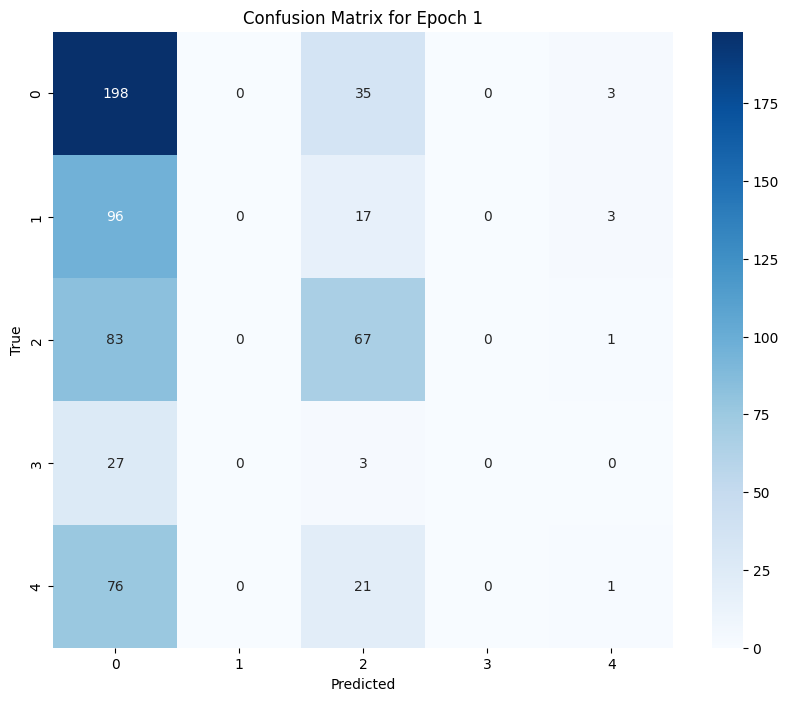

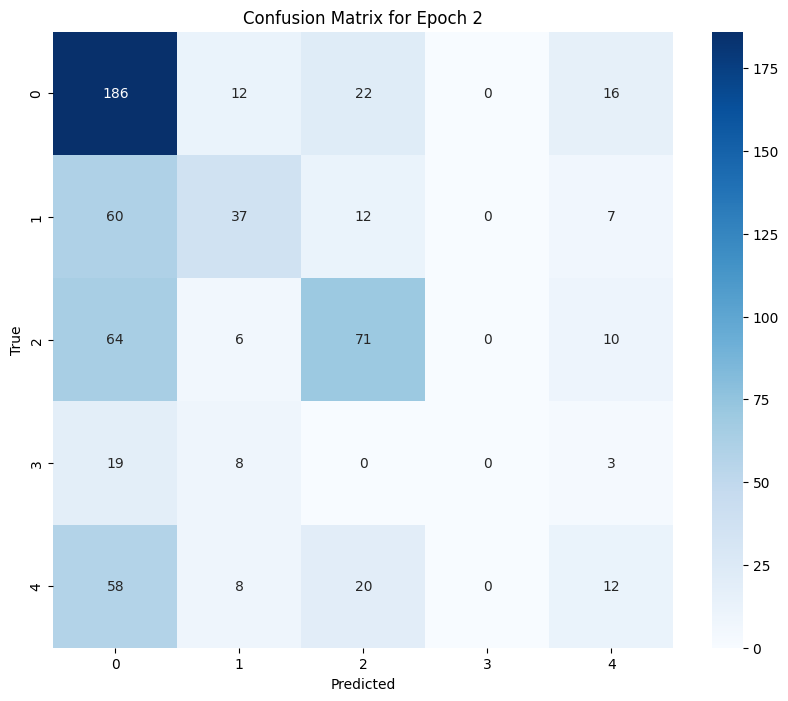

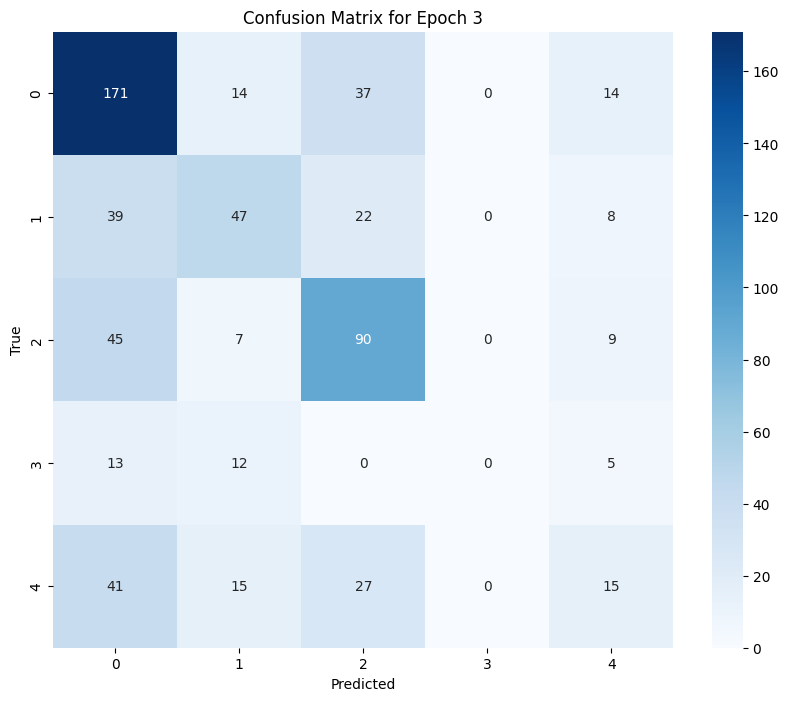

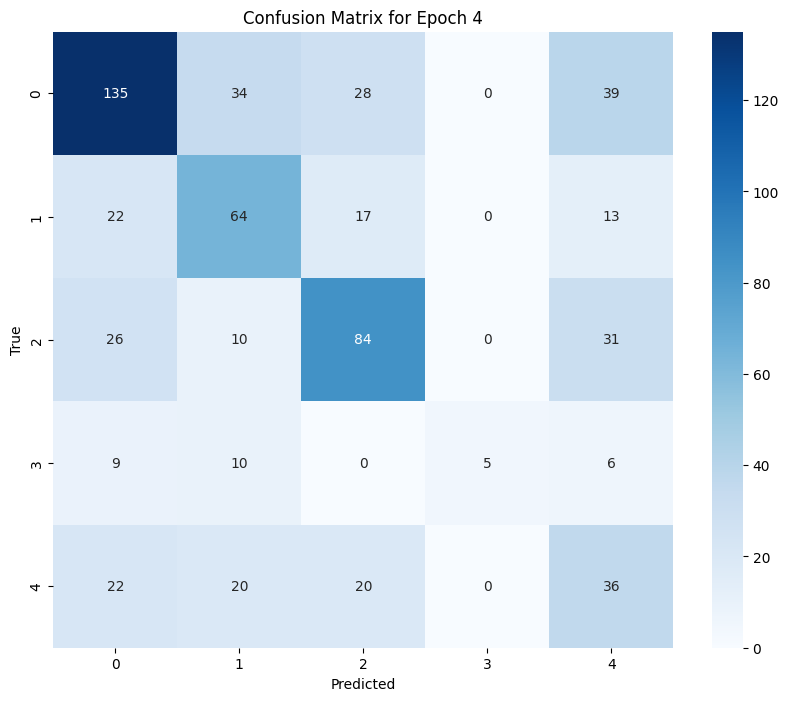

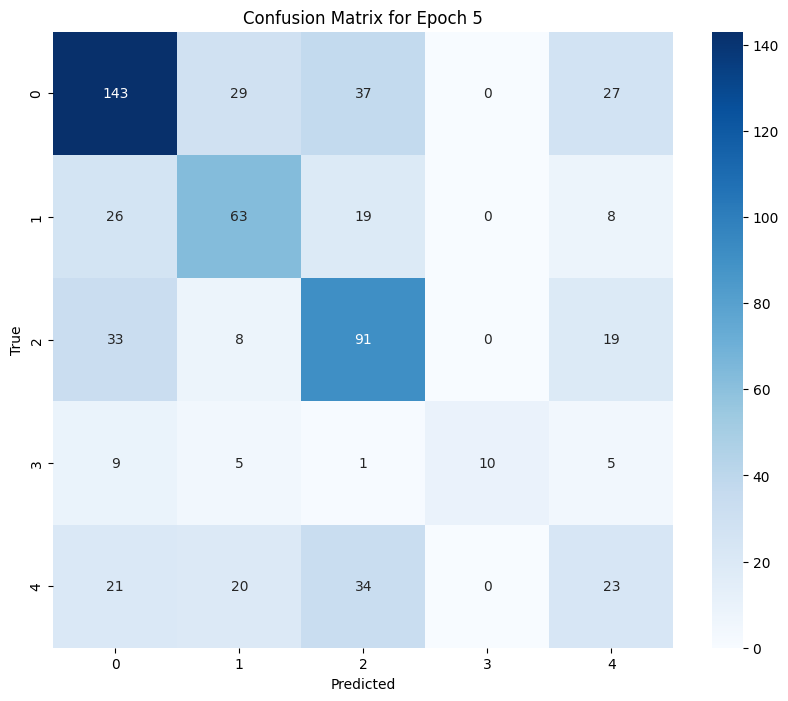

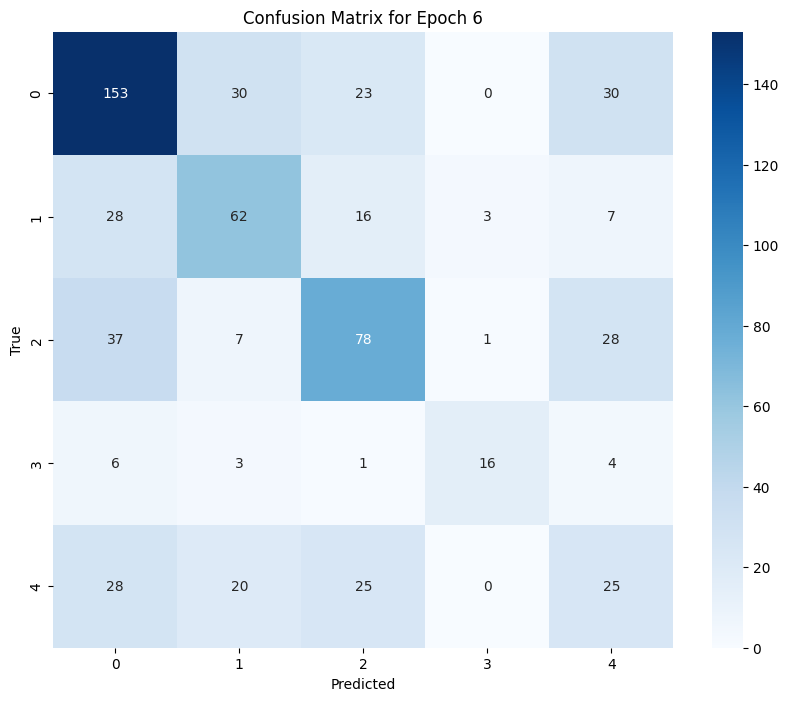

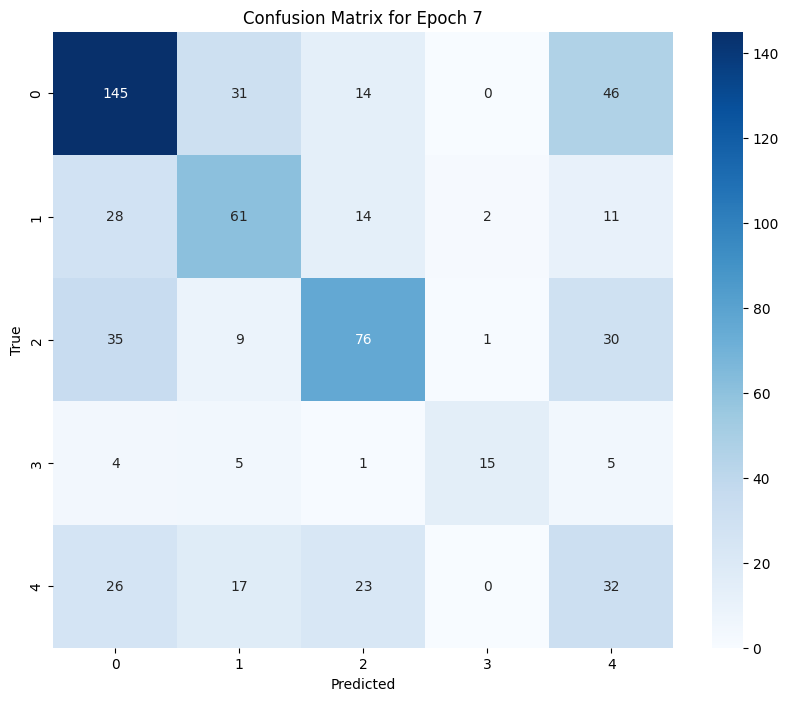

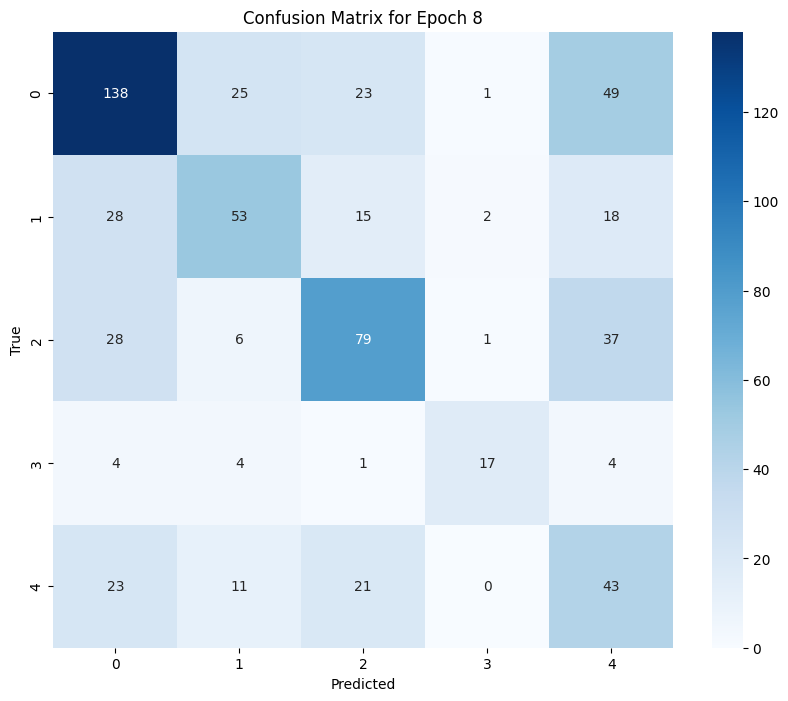

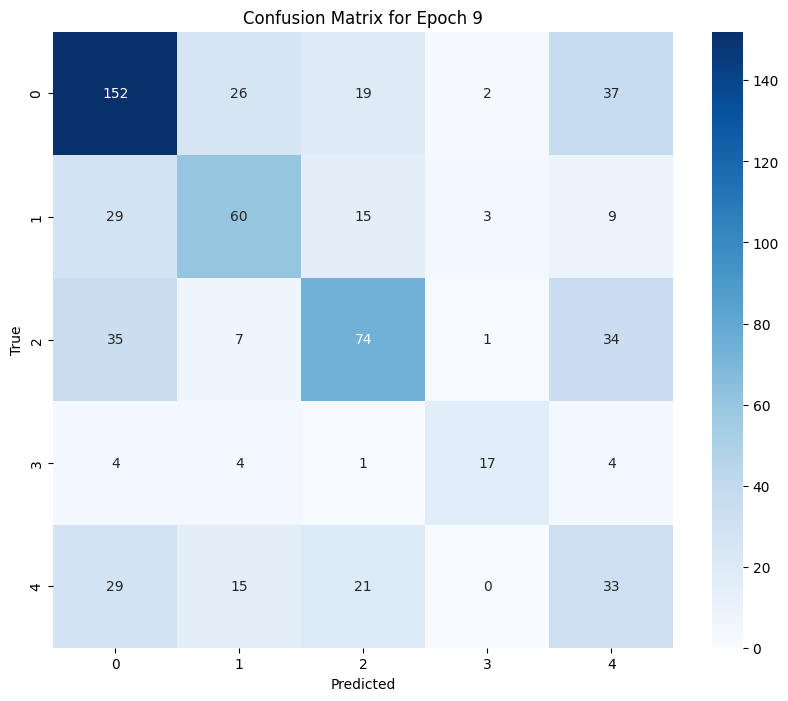

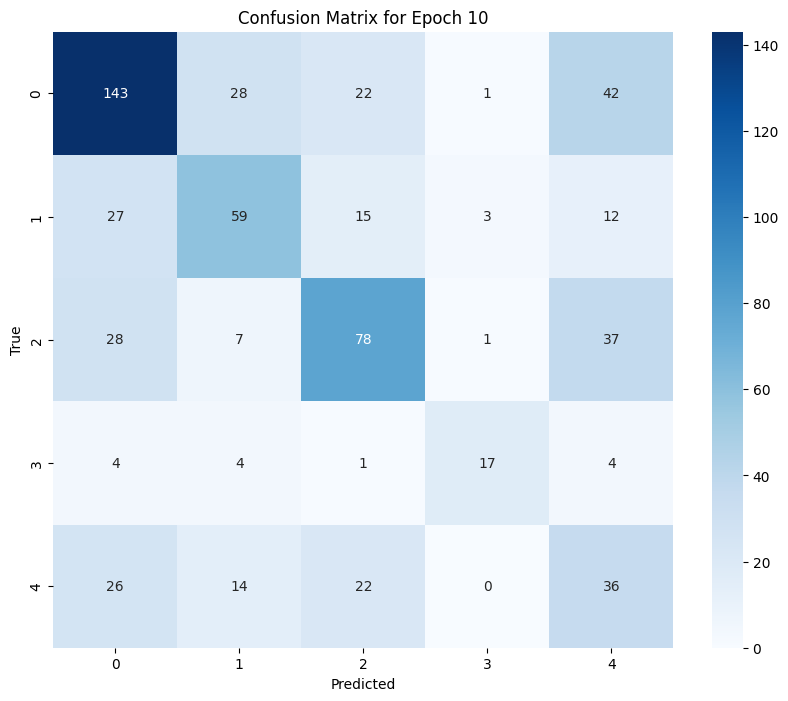

In [19]:
# Plot confusion matrix
for idx, cm in enumerate(cms):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(cm.shape[1]), yticklabels=range(cm.shape[0]))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for Epoch {idx + 1}')
    plt.savefig(f'confusion_matrix_epoch_{idx + 1}.png')
    plt.show()

#### CLICK HERE TO EXPEND CELL AND VIEW THE MATRIX APPEAR WITH THE CORRECT FORM, THE MATRIX BELOW IS A EXAMPLE AND IT DOES NOT RERESENTS THE CONFUSION MATRIX OF FAMILY GUY DIALOGUES

-In the confussion matrix graphics, each row represents the true class, and each column represents the predicted class.

-The diagonal elements are te true positives for each label. The other elements (off-diagonal elements) are the misclassifications, by example:

Predicted
         0    1    2    3    4    5    6    7    8    9
Actual
    0   50    2    1    0    0    0    0    0    1    0
    1    3   45    2    0    0    0    0    0    0    0
    2    0    1   48    0    1    0    0    0    0    0
    3    0    0    0   52    2    1    0    0    0    0
    4    0    0    0    2   46    0    1    0    0    0
    5    0    0    0    0    0   50    1    1    0    0
    6    0    0    0    0    0    1   52    0    0    0
    7    0    0    0    0    0    0    0   50    0    1
    8    1    0    0    0    0    0    0    1   48    1
    9    0    0    0    0    0    0    0    0    0   52

For instance, for class 0, there are 2 instances misclassified as class 1.

## Reasons to have not good result
<ol>
    <li>Dialogos curtos são difíceis de distinguir</li>
    <li>Quantidade de diálogos mapeados para os personagens é muito pequeno comparado ao dataset todo.</li>
    <li>Aproximadamente 25% dos diálogos mapeados são diálogos do Peter Griffin, os demais diálogos são para todos os demais personagens da série.</li>
</ol>